# Structure preserving Gaussian image denoising

Evaluate SPGD on a Zero-mean Mixed Poisson-Gaussian (0MMPG) noisy versions of Barb. See notebooks averaging_denoising.ipynb and gaussian_denoising.ipynb.

In [1]:
local_debug = True

In [2]:
import time
from collections import namedtuple

try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

import scipy.ndimage

try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker

#from ipywidgets import *
try:
    import cv2
except:
    !pip install cv2
    import cv2
    
#import kernels
try:
    from skimage import io as skimage_io
except:
    !pip install scikit-image
    from skimage import io as skimage_io

try:
    import information_theory as IT
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    import information_theory as IT

In [3]:
# apt install cm-super-minimal
# apt install dvipng
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Helvetica",
    "font.family": "Serif",
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amsfonts}"
})
#rc('text', usetex=True)
#rc('font', family='serif')
#plt.rc('text.latex', preamble=r'\usepackage{amsmath} `...')
#mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amsfonts}'

In [4]:
import logging
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)
#logger.setLevel(logging.INFO)

In [5]:
if local_debug:
    !ln -sf ../src/denoising .
else:
    !pip install "denoising @ git+https://github.com/vicente-gonzalez-ruiz/denoising"

In [6]:
if local_debug:
    !ln -sf ../../motion_estimation/src/motion_estimation/ .
else:
    !pip install "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"

In [7]:
if local_debug:
    !ln -sf ../../self_fourier_shell_correlation/src/self_fourier_shell_correlation/ .
else:
    !pip install "self_fourier_shell_correlation @ git+https://github.com/vicente-gonzalez-ruiz/self_fourier_shell_correlation"

In [8]:
import denoising.image.OF_gaussian__OpenCV as denoising
denoiser = denoising.Monochrome_Denoising(logger, N_poly=3, window_side=5)

In [9]:
#import denoising.image.gaussian as denoising
#denoiser = denoising.Monochrome_Denoising(logger)

In [10]:
from self_fourier_shell_correlation import fsc_utils as fsc

### barb

In [11]:
Args = namedtuple("args", "input")
#args = Args("http://www.hpca.ual.es/~vruiz/images/barb.png")
args = Args("barb.png")

In [12]:
X = skimage_io.imread(args.input)  # Ground Truth

In [13]:
padded_X = np.zeros(shape=(X.shape[0]+32, X.shape[1]+32), dtype=np.uint8)
padded_X[16:-16, 16:-16] = X
X = padded_X

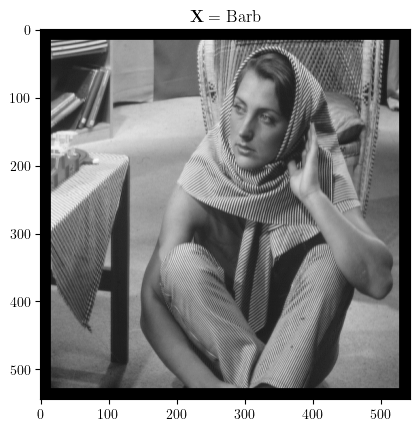

In [14]:
plt.title(r"$\mathbf{X}=\mathrm{Barb}$")
plt.imshow(X, cmap="gray")
#plt.savefig('barb.pdf', bbox_inches='tight')

In [15]:
def MPG_noise(X, std_dev=10.0, gamma=0.1, poisson_ratio=0.5):
    N_poisson = np.random.poisson(X * gamma)/gamma
    N_gaussian = np.random.normal(loc=0, scale=std_dev, size=X.size)
    N_gaussian = np.reshape(N_gaussian, X.shape)
    Y = (1 - poisson_ratio) * (X + N_gaussian) + poisson_ratio * N_poisson
    #Y = np.clip(Y, 0, 255)
    #Y = N_gaussian + N_poisson
    #Y = N_gaussian + gamma*N_poisson
    #Y = N_poisson
    #Y = N_gaussian + X
    return Y

### 0MMPG_barb

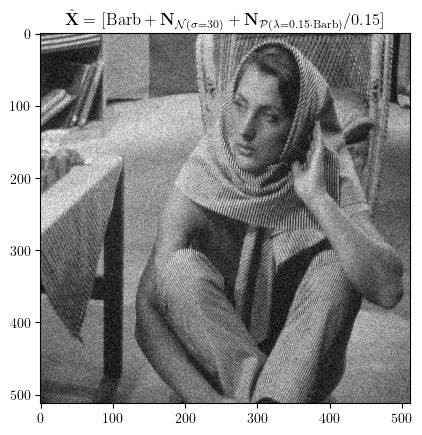

In [16]:
gamma = 0.15
std_dev = 30
string  = r'$\hat{\mathbf{X}}=['
string += r"\mathrm{Barb} + \mathbf{N}_{\mathcal{N}"
string += r"(\sigma"
string += f"={std_dev})"
string += r'}'
string += r" + \mathbf{N}_{\mathcal{P}"
string += r"(\lambda"
string += f"={gamma}"
string += r'\cdot\mathrm{Barb})}'
string += f"/{gamma}"
string += ']$'
plt.title(string) 
Y = MPG_noise(X, std_dev, gamma).reshape(X.shape)
Y = np.clip(a = Y, a_min=0, a_max=255)
plt.imshow(Y[16:-16, 16:-16], cmap="gray")
plt.savefig('0MMPG_barb.pdf', bbox_inches='tight')

### SPGD_0MMPG_barb

In [17]:
def get_gaussian_kernel(sigma=1):
    number_of_coeffs = 3
    number_of_zeros = 0
    while number_of_zeros < 2 :
        delta = np.zeros(number_of_coeffs)
        delta[delta.size//2] = 1
        coeffs = scipy.ndimage.gaussian_filter1d(delta, sigma=sigma)
        number_of_zeros = coeffs.size - np.count_nonzero(coeffs)
        number_of_coeffs += 1
    return coeffs[1:-1]

0.9999999999999999


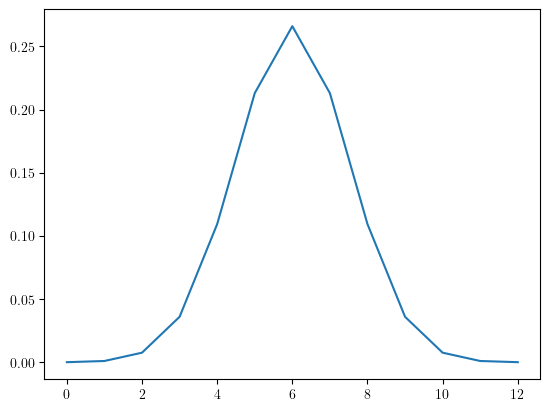

In [21]:
sigma_kernel = 1.5
sigma = np.array([sigma_kernel, sigma_kernel])
kernel = [None]*2
kernel[0] = get_gaussian_kernel(sigma[0])
kernel[1] = get_gaussian_kernel(sigma[1])
print(np.sum(kernel[0]))
plt.plot(kernel[0])
plt.show()

In [28]:
denoised = denoiser.filter(
    noisy_img=Y,
    kernel=kernel,
    l=3,
    w=3,
    w_poly=5, sigma_poly=1.2, flags=0, iterations=3)

v3
v3


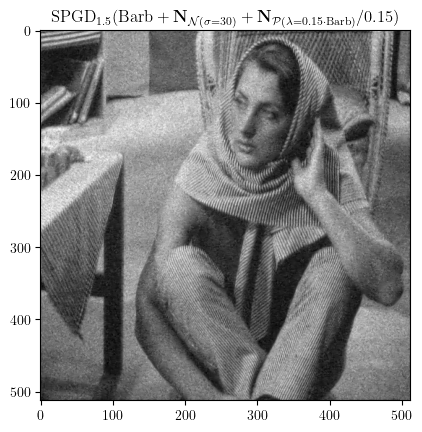

In [29]:
string  = r"$\mathrm{SPGD}_{\text{"
string += str(sigma_kernel)
string += r"}}(\mathrm{Barb} + \mathbf{N}_{\mathcal{N}"
string += r"(\sigma"
string += f"={std_dev})"
string += r'}'
string += r" + \mathbf{N}_{\mathcal{P}"
string += r"(\lambda"
string += f"={gamma}"
string += r'\cdot\mathrm{Barb})}'
#string += rf"$_{(\sigma^2={std_dev}^2)}$"
string += f"/{gamma})"
string += '$'
plt.title(f"{string}")
plt.imshow(denoised[16:-16, 16:-16], cmap="gray")
plt.savefig('SPGD_0MMPG_barb.pdf', bbox_inches='tight')

### SPGD_PCC_0MMPG_barb__tau

In [ ]:
# Noise configuration (Poisson noise remains constant)
sigmas_noise = [i for i in range(0, 100, 20)]
gamma_noise = 0.15
poisson_ratio = 0.5
print(sigmas_noise)

In [ ]:
# Denoising configuration: explore only the kernel length
sigmas_kernel = [(1.0 + i/2) for i in range(10)]
print(sigmas_kernel)

In [ ]:
#X = X[10:50,10:50]

In [ ]:
PCC_curves = [] # One curve for each kernel length
for sigma_noise in sigmas_noise:
    #gamma = std_dev / 50
    curve = []
    for sigma_kernel in sigmas_kernel:
        time0 = time.time()
        print("sigma_noise", sigma_noise, "sigma_kernel", sigma_kernel, "gamma", gamma, "poisson_ratio", poisson_ratio, end=' ')
        #sigma_kernel /= 10
        sigma = np.array([sigma_kernel, sigma_kernel])
        kernel = [None]*2
        kernel[0] = get_gaussian_kernel(sigma[0])
        kernel[1] = get_gaussian_kernel(sigma[1])
        Y = MPG_noise(X, sigma_noise, gamma, poisson_ratio).reshape(X.shape)
        #Y = np.clip(a = Y, a_min=0, a_max=255)
        denoised = denoiser.filter(Y, kernel)
        #PSNR = IT.distortion.PSNR(denoised, X)
        PCC = np.corrcoef(denoised.flatten(), X.flatten())[0, 1]
        print("PCC", PCC, end=' ')
        curve.append(PCC)
        plt.imshow(denoised, cmap="gray")
        plt.show()
        #input()
        time1 = time.time() - time0
        print("time", time1)

    PCC_curves.append(curve)
    #sigma_index += 1
    print()

In [ ]:
i = 0
for sigma_noise in sigmas_noise:
    plt.plot(
        sigmas_kernel,
        PCC_curves[i],
        label=rf"$\sigma={sigma_noise}, \gamma={gamma}"
        + r", \mathrm{argmax}_\tau="
        + rf"{sigmas_kernel[np.argmax(PCC_curves[i])]:.2f}$",
        marker='o')
    i += 1
string  = r"$"
string += r"\mathrm{PCC}"
string += r"(\mathbf{X}, "
string += r"\mathrm{SPGD}_\tau"
string += r"(\mathbf{X}"
string += r"+ \mathbf{N}_{\mathcal{N}"
string += r"(\sigma)}"
string += r"+ \mathbf{N}_"
string += r"{\mathcal{P}(\gamma\mathbf{X})}/\gamma))$"
plt.ylabel(string)
#plt.ylabel(r"$\mathrm{PCC}(\mathbf{X}, \hat{\mathbf{X}})$")
plt.xlabel(r"$\tau$")
plt.legend()
#plt.show()
plt.savefig("SPGD_PCC_0MMPG_barb.pdf", bbox_inches='tight')

### SPGD_SFRC_0MMPG_barb__tau

In [ ]:
sigmas_kernel = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
std_dev = 40
SFRC_curve = []
for i in sigmas_kernel: # We want to see a different curve for each filter length
    time0 = time.time()
    kernel = [None]*2
    kernel[0] = get_gaussian_kernel(i)
    kernel[1] = get_gaussian_kernel(i)
    total_c_avg = np.zeros(X.shape[0]>>1)
    Y = MPG_noise(X, std_dev, gamma, poisson_ratio).reshape(X.shape)
    #Y = np.clip(a = Y, a_min=0, a_max=255)
    denoised = denoiser.filter(Y, kernel)
    plt.imshow(denoised, cmap="gray")
    plt.show()
    freq, c_avg = fsc.get_SFRC_curve(denoised)
    #freq, c_avg = fsc.get_SFRC_curve(X)
    #freq = freq[:(len(freq)>>1)]
    #c_avg = c_avg[:(len(c_avg)>>1)]
    SFRC_curve.append(c_avg)
    time1 = time.time() - time0
    first_half = c_avg[:len(c_avg)>>1]
    #second_half = SFRC_curve[i][len(curve[i])>>1:]
    print(i, "time:", time1, "area:", np.sum(first_half))

#sigmas_kernel = [(0.25 + i/10) for i in range(20)]
sigmas_kernel = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
#sigmas_kernel = [6.0, 8.0, 10.0, 12.0, 14.0]
curve = []
gamma = 0.15
std_dev = 30
for i in sigmas_kernel:
    total_c_avg = 0
    kernel = [None]*2
    kernel[0] = get_gaussian_kernel(i)
    kernel[1] = get_gaussian_kernel(i)
    total_c_avg = np.zeros(X.shape[0]>>1)
    for j in range(1):
        Y = MPG_noise(X, std_dev, gamma).reshape(X.shape)
        Y = np.clip(a = Y, a_min=0, a_max=255)
        denoised = denoiser.filter(Y, kernel)
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        freq, c_avg = fsc.get_SFRC_curve(denoised)
        #freq, c_avg = fsc.get_SFRC_curve(X)
        #freq = freq[:(len(freq)>>1)]
        #c_avg = c_avg[:(len(c_avg)>>1)]
        total_c_avg += c_avg
    curve.append(total_c_avg/1)
    print(i, end=' ')

In [ ]:
#plt.title(r"$\mathbf{X}=\mathrm{Barb}$")
plt.xlabel(r"$\omega$")
string  = r"$\mathrm{SFRC}"
string += r"(\mathrm{SPGD}_\tau("
string += r"\mathbf{X} + \mathbf{N}_{\mathcal{N}"
string += r"(\sigma="
string += f"{std_dev}"
string += r")}"
string += r"+ \mathbf{N}"
string += r"_{\mathcal{P}("
string += rf"{gamma}"
string += r"\mathbf{X})}/" + rf"{gamma}" + r"))$"
plt.ylabel(string)
#plt.ylabel(r"$\mathrm{SFRC}(\tilde{\mathbf{X}})$")
markers = ['o', 's', '^', 'd', 'x', '*', 'v', 'p', 'h', '+']  # Add more markers if needed
#for i in range(len(sigmas_kernel)):
#for i in range(len(sigmas_kernel)-1, 0, -1):
i = 0
for sigma_kernel in sigmas_kernel:
    #plt.plot(freq, curve[i], label=r"$\tau=" + f"{sigmas_kernel[i]}" + r"$", marker=markers[(len(sigmas_kernel)-i-1) % len(markers)], markersize=0.0)
    #plt.plot(freq, curve[i], label=r"$\tau=" + f"{sigmas_kernel[len(sigmas_kernel)-i-1]}" + r"$", marker=markers[(len(sigmas_kernel)-i-1) % len(markers)], markersize=0.0)
    first_half = SFRC_curve[i][:len(SFRC_curve[i])>>1]
    second_half = SFRC_curve[i][len(SFRC_curve[i])>>1:]
    #plt.plot(freq, curve[i], label=r"$\tau=" + f"{sigmas_kernel[i]}" + r", \mathrm{sum}=" + f"{int(np.sum(first_half)-np.sum(second_half))}"  + r"$", marker=markers[i % len(markers)], markersize=0.0)
    plt.plot(
        freq[:len(SFRC_curve[i])>>1],
        SFRC_curve[i][:len(SFRC_curve[i])>>1],
        label=r"$\tau="
        + f"{sigmas_kernel[i]}"
        + r", \mathrm{sum}="
        + f"{np.sum(first_half):.2f}"
        + r"$", marker=markers[i % len(markers)],
        markersize=0.0)
    i += 1
plt.legend()
plt.savefig("SPGD_SFRC_0MMPG_barb.pdf", bbox_inches='tight')

### SPGD_PCC_0MMPG_barb__N_poly

In [ ]:
sigma_kernel = 3.5
sigma = np.array([sigma_kernel, sigma_kernel])
kernel = [None]*2
kernel[0] = get_gaussian_kernel(sigma[0])
kernel[1] = get_gaussian_kernel(sigma[1])
print(np.sum(kernel[0]))
plt.plot(kernel[0])
plt.show()

In [ ]:
gamma = 0.15
std_dev = 30

In [ ]:
curve_n = []
n_s = range(2,7)
for i in n_s:
    denoiser = denoising.Monochrome_Denoising(logger, N_poly=i, window_side=9)
    Y = MPG_noise(X, std_dev, gamma).reshape(X.shape)
    Y = np.clip(a = Y, a_min=0, a_max=255)
    denoised = denoiser.filter(Y, kernel)
    PCC = np.corrcoef(denoised.flatten(), X.flatten())[0, 1]
    print(i, PCC)
    curve_n.append(PCC)
    plt.imshow(denoised, cmap="gray")
    plt.show()

In [ ]:
plt.title(r"$\mathbf{X}=\mathrm{Barb}$")
plt.xlabel(r"$n$")
plt.ylabel("PCC")
plt.plot(n_s, curve)

### SPGD_SRFC_0MMPG_barb__N_poly

### SPGD_PCC_0MMPG_barb__w

### SPGD_SFRC_0MMPG_barb__w

In [ ]:
sigma_kernel = 3.5
sigma = np.array([sigma_kernel, sigma_kernel])
kernel = [None]*2
kernel[0] = get_gaussian_kernel(sigma[0])
kernel[1] = get_gaussian_kernel(sigma[1])
print(np.sum(kernel[0]))
plt.plot(kernel[0])
plt.show()

In [ ]:
#sigmas_kernel = [(0.25 + i/10) for i in range(20)]
w_s = range(3, 11, 2)
curve = []
gamma = 0.15
std_dev = 30
N_poly = 4
for i in w_s:
    denoiser = denoising.Monochrome_Denoising(logger, N_poly=N_poly, window_side=i)
    Y = MPG_noise(X, std_dev, gamma).reshape(X.shape)
    Y = np.clip(a = Y, a_min=0, a_max=255)
    denoised = denoiser.filter(Y, kernel)
    plt.imshow(denoised, cmap="gray")
    plt.show()
    freq, c_avg = fsc.get_SFRC_curve(denoised)
    curve.append(c_avg)
    print(i, end=' ')

In [ ]:
plt.title(r"$\mathbf{X}=\mathrm{Barb}$")
plt.xlabel(r"$n$")
plt.ylabel("PCC")
plt.plot(n_s, curve)